### Figure MF-Windspeed 

original draft of code: SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb

(co

In [53]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [54]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [55]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut
from scipy import stats

import pymannkendall as mk

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [56]:
def make_yearlist_UKESM(yrst, yrend, scen = '1A'):
    
    baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/UKESM_{scen}_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist



## colour and scenario definitions

In [57]:
scendict = {
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'runid':'TOM12_TJ_1AA1'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'runid':'TOM12_TJ_1BA1'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'runid':'TOM12_TJ_2AA1'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'runid':'TOM12_TJ_2BA1'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'runid':'TOM12_TJ_3AA1'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'runid':'TOM12_TJ_3BA1'},
    'PI': {
        'hist_str': '',
        'fut_str': '',
        'name': 'PI OZONE \n PI TEMP.',
        'name2':'PI: OzonePI-PI',
        'color':'silver',
        'runid':'TOM12_TJ_PIA1'}
}


## code to extract overwater wind speed 

(done originally in SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb)

In [58]:
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
tmask = cdomask.tmask

extract = False

if extract:
    
    ylist_UKESM_1A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '1A'))
    ylist_UKESM_2A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '2A'))
    ylist_UKESM_3A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '3A'))
    ylist_UKESM_1B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '1B'))
    ylist_UKESM_2B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '2B'))
    ylist_UKESM_3B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '3B'))
    ylist_UKESM_PI = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, 'PI'))

    savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam)
    tmask = cdomask.tmask
    
    t1 = 1950; t2 = 2101
    baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

    test = ylist_UKESM_1A.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_1A_wspd10m_overwater-50S-mean.nc')

    test = ylist_UKESM_2A.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_2A_wspd10m_overwater-50S-mean.nc')

    test = ylist_UKESM_3A.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_3A_wspd10m_overwater-50S-mean.nc')
    ##
    test = ylist_UKESM_1B.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_1B_wspd10m_overwater-50S-mean.nc')

    test = ylist_UKESM_2B.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_2B_wspd10m_overwater-50S-mean.nc')

    test = ylist_UKESM_3B.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_3B_wspd10m_overwater-50S-mean.nc')

    test = ylist_UKESM_PI.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_PI_wspd10m_overwater-50S-mean.nc')

In [59]:
baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

wspd_PI = xr.open_dataset(f'{baseDir}/UKESM_PI_wspd10m_overwater-50S-mean.nc')
wspd_1A = xr.open_dataset(f'{baseDir}/UKESM_1A_wspd10m_overwater-50S-mean.nc')
wspd_2A = xr.open_dataset(f'{baseDir}/UKESM_2A_wspd10m_overwater-50S-mean.nc')
wspd_3A = xr.open_dataset(f'{baseDir}/UKESM_3A_wspd10m_overwater-50S-mean.nc')
wspd_1B = xr.open_dataset(f'{baseDir}/UKESM_1B_wspd10m_overwater-50S-mean.nc')
wspd_2B = xr.open_dataset(f'{baseDir}/UKESM_2B_wspd10m_overwater-50S-mean.nc')
wspd_3B = xr.open_dataset(f'{baseDir}/UKESM_3B_wspd10m_overwater-50S-mean.nc')

## Figure code

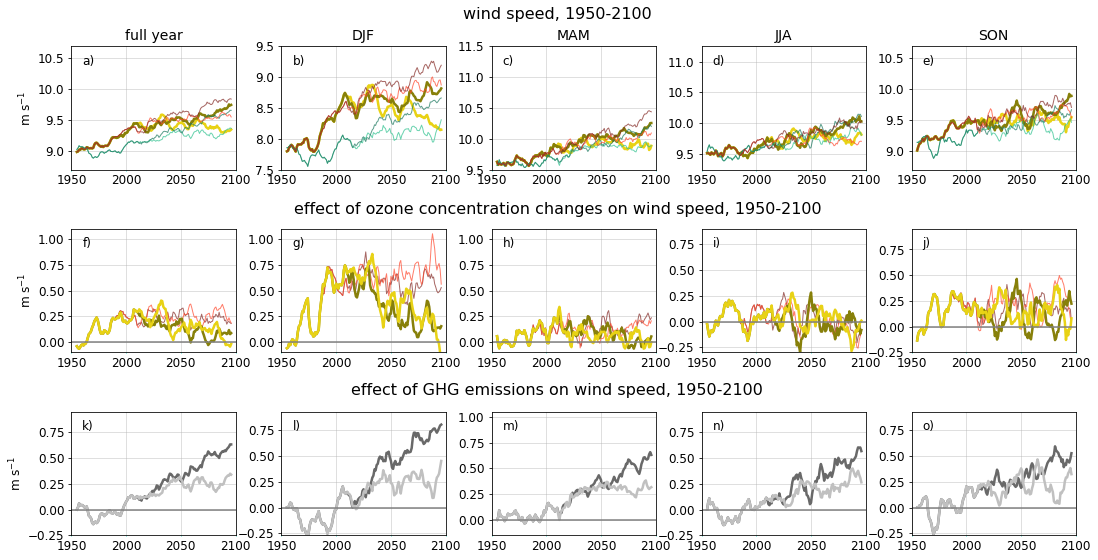

In [72]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)


fact = 1
fig, axs = plt.subplots(3,5, figsize=(18*fact, 9*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
wspdset = [wspd_1A, wspd_1B, wspd_2A, wspd_2B, wspd_3A, wspd_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']
lws = [2.5, 2.5, 1, 1, 1, 1]
talph = [1, 1, 0.7, 0.7, 0.7, 0.7]
wspd_2A_50 = wspd_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
wspd_2B_50 = wspd_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

wspdset_o3 = [(wspd_3B-wspd_2B), (wspd_3A-wspd_2A), (wspd_1B-wspd_2B), (wspd_1A-wspd_2A)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
scens_o3 = ['ozone depl.-fixed ozone \n (SSP 3-7.0)', 'ozone depl.-fixed ozone \n (SSP 1-2.6)',\
            'ozone rec .-fixed ozone \n (SSP 3-7.0)', 'ozone rec .-fixed ozone \n (SSP 1-2.6)']
lws_o3 = [1, 1, 2.5, 2.5]
talph_o3 = [0.7, 0.7, 1, 1]

cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']
cols_t = ['dimgrey', 'silver']
scens_t = ['fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 3-7.0)',\
           'fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 1-2.6)']

var = 'wspd10m'; vardesc = 'wind speed'; ylab = 'm s$^{-1}$'

############## lines
tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i])

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth =  lws[x], alpha = talph[x], label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth  = lws[x], alpha = talph[x], label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth  = lws[x], alpha = talph[x])

##########################
# #### ozone effect

ind = 5
for x in range(0,4):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = lws_o3[x], alpha = talph_o3[x], label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth  = lws_o3[x], alpha = talph_o3[x], label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2+ind], color = cols_o3[x], linewidth  = lws_o3[x], alpha = talph_o3[x], label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3+ind], color = cols_o3[x], linewidth  = lws_o3[x], alpha = talph_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4+ind], color = cols_o3[x], linewidth  = lws_o3[x], alpha = talph_o3[x])
    
# ######################
# #### temperature effect
ind = 10; tlw = 2.5
tv = wspd_2B[var].groupby('time_counter.year').mean()-\
wspd_2B_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])
    
tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])    
    
tv = wspd_2A[var].groupby('time_counter.year').mean()-\
wspd_2A_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])
    
tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])  
#############################################


##################
### titles, etc
plt.subplots_adjust(hspace = 0.48 )
plt.subplots_adjust(wspace = 0.28 )
t1 = 'wind speed, 1950-2100'
t2 = 'effect of ozone concentration changes on wind speed, 1950-2100'
t3 = 'effect of GHG emissions on wind speed, 1950-2100'
t4 = 'effect of ozone concentration changes and GHG emissions on wind speed, $\overline{2090-2100} - \overline{1950-1960}$'

fs = 16


for i in range(0,15):
    axs[i].tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
    axs[i].grid(alpha = 0.5)
    
for i in range(0,15):
    axs[i].set_xlim([1950,2100])
    axs[i].set_xlabel('')
    
for i in range(1,15):
    axs[i].set_xlim([1950,2100])
    axs[i].set_ylabel('')
    
for i in range(0,15):
    #axs[i].set_xlim([1950,2100])
    #axs[i].set_ylabel('')
    axs[i].axhline(y=0, color = 'grey')
    
lab = ['a)','b)','c)','d)','e)',] 
ymi = np.array([8.7,7.5,9.5,9.25,8.7])  
hi = 2
for i in range(0,5):
    axs[i].set_ylim([ymi[i],ymi[i]+hi])
    axs[i].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['f)','g)','h)','i)','j)']  
ymi = np.array([-0.1,-0.1,-0.1,-0.3,-0.25])  
hi = 1.2
for i in range(0,5):
    axs[i+5].set_ylim([ymi[i],ymi[i]+hi])
    axs[i+5].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['k)','l)','m)','n)','o)']  
ymi = np.array([-0.25,-0.27,-0.15,-0.25,-0.27])  
for i in range(0,5):
    axs[i+10].set_ylim([ymi[i],ymi[i]+hi])
    axs[i+10].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['p)','q)','r)','s)','t)']  
ymi = np.array([-0.2,-0.2,-0.2,-0.2,-0.2])
hi = 1.1


tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i], fontsize = fs-2)

plt.subplots_adjust(hspace = 0.48 )
plt.subplots_adjust(wspace = 0.28 )
t1 = 'wind speed, 1950-2100'
t2 = 'effect of ozone concentration changes on wind speed, 1950-2100'
t3 = 'effect of GHG emissions on wind speed, 1950-2100'

axs[0].set_ylabel('m s$^{-1}$')
axs[5].set_ylabel('m s$^{-1}$')
axs[10].set_ylabel('m s$^{-1}$')


fs = 16
plt.subplots_adjust(hspace = 0.48 )
plt.subplots_adjust(wspace = 0.28 )
plt.figtext(0.5,0.94, t1, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.64, t2, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.36, t3, ha="center", va="top", fontsize=fs, color="k")


fname = './figs/MF-windspeed.jpg'
fig.savefig(fname, transparent=None, dpi=250, format=None,
        metadata=None, bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None,
       )